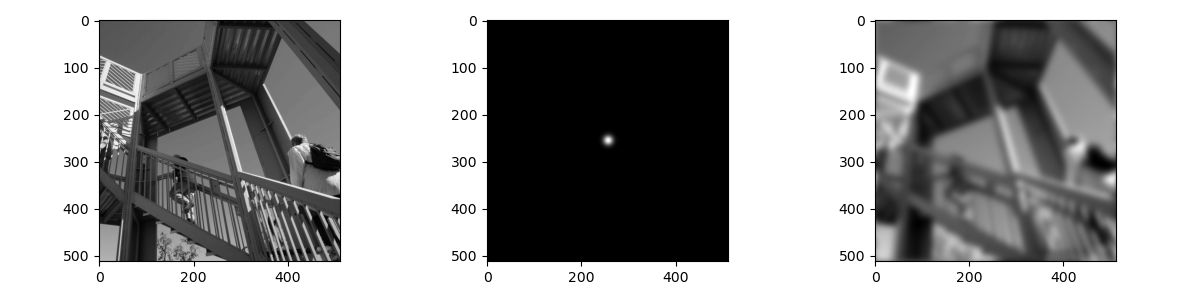

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import ascent

import pyopencl as cl
import pyopencl.array as cla
from pyvkfft.opencl import VkFFTApp
from pyvkfft.fft import rfftn, irfftn, fftn, ifftn

cl_ctx = cl.create_some_context()
cq = cl.CommandQueue(cl_ctx)

d = ascent()
n = len(d)
y, x = np.meshgrid(np.arange(-n//2,n//2), np.arange(-n//2,n//2), indexing='ij')
g = np.fft.fftshift(np.exp(-(x**2+y**2)/100))
g /= g.sum()

# move data to GPU
d_gpu = cla.to_device(cq, d.astype(np.float32))
g_gpu = cla.to_device(cq,g.astype(np.float32))

# convolution
gd_gpu = irfftn(rfftn(d_gpu) * rfftn(g_gpu))

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(d, cmap='gray')
plt.subplot(132)
plt.imshow(np.fft.fftshift(g), cmap='gray')
plt.subplot(133)
plt.imshow(gd_gpu.get(), cmap='gray')
plt.tight_layout()


VkFFTApp[OpenCL]:(512,510+2)     R2C/s/i [rR] [11] buf=    0       0  


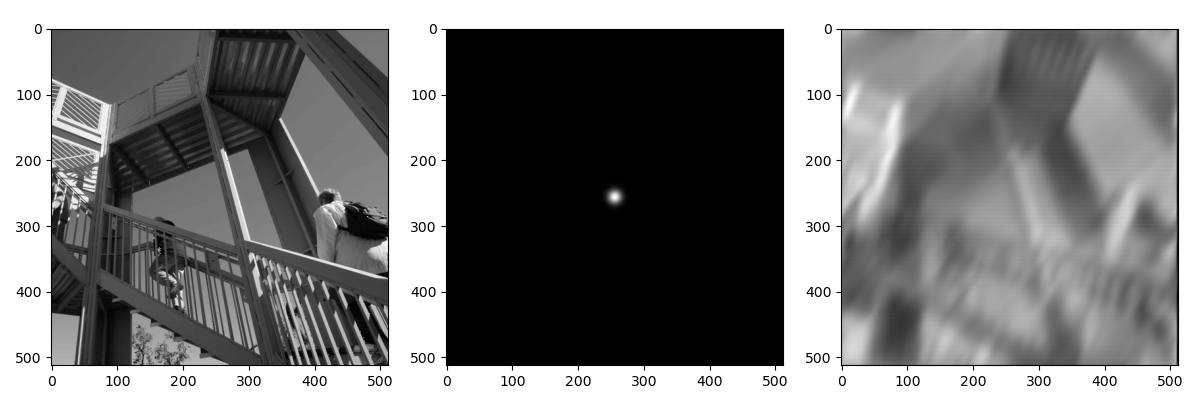

In [2]:
# Try inplace R2C VkFFT convolve
d_gpu = cla.to_device(cq, d.astype(np.float32))
g_gpu = cla.to_device(cq, g.astype(np.float32))

k_gpu = rfftn(g_gpu)

app = VkFFTApp(d.shape, dtype=np.float32, queue=cq, ndim=2, inplace=True,r2c=True,convolve=True, convolve_conj=0)
app.fft(d_gpu,convolve_kernel=k_gpu)
print(app, app.get_tmp_buffer_str())

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(d, cmap='gray')
plt.subplot(132)
plt.imshow(np.fft.fftshift(g), cmap='gray')
plt.subplot(133)
plt.imshow(d_gpu.get(), cmap='gray')
plt.tight_layout()


VkFFTApp[OpenCL]:(512,512)       R2C/s/o [rr] [11] buf=    0       0  


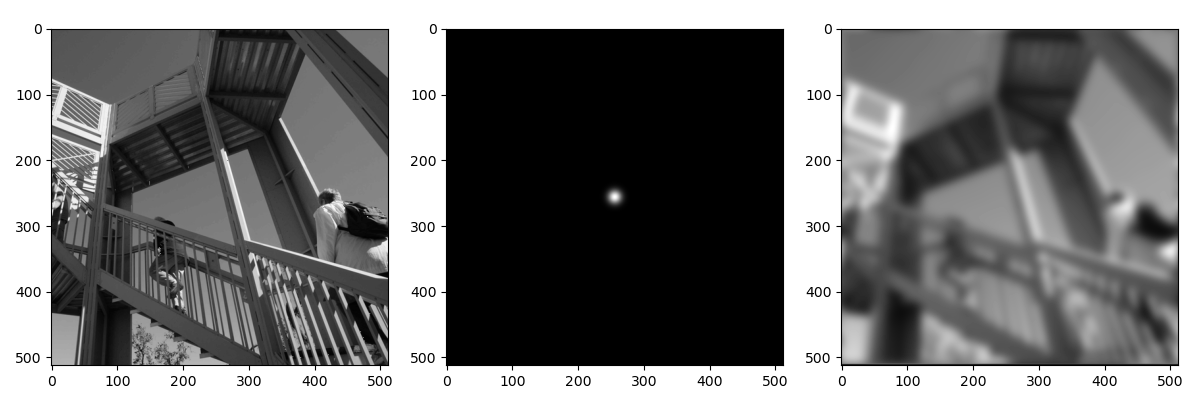

In [3]:
# Try out-of-place R2C VkFFT convolve
d_gpu = cla.to_device(cq, d.astype(np.float32))
g_gpu = cla.to_device(cq, g.astype(np.float32))
gd_gpu = cla.empty_like(d_gpu)

k_gpu = rfftn(g_gpu)

app = VkFFTApp(d.shape, dtype=np.float32, queue=cq, ndim=2, inplace=False,r2c=True,convolve=True, convolve_conj=0)
app.fft(src=d_gpu, dest=gd_gpu,convolve_kernel=k_gpu)
print(app, app.get_tmp_buffer_str())

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(d, cmap='gray')
plt.subplot(132)
plt.imshow(np.fft.fftshift(g), cmap='gray')
plt.subplot(133)
plt.imshow(d_gpu.get(), cmap='gray')
plt.tight_layout()


VkFFTApp[OpenCL]:(512,512)       C2C/s/i [rr] [11] buf=    0       0  


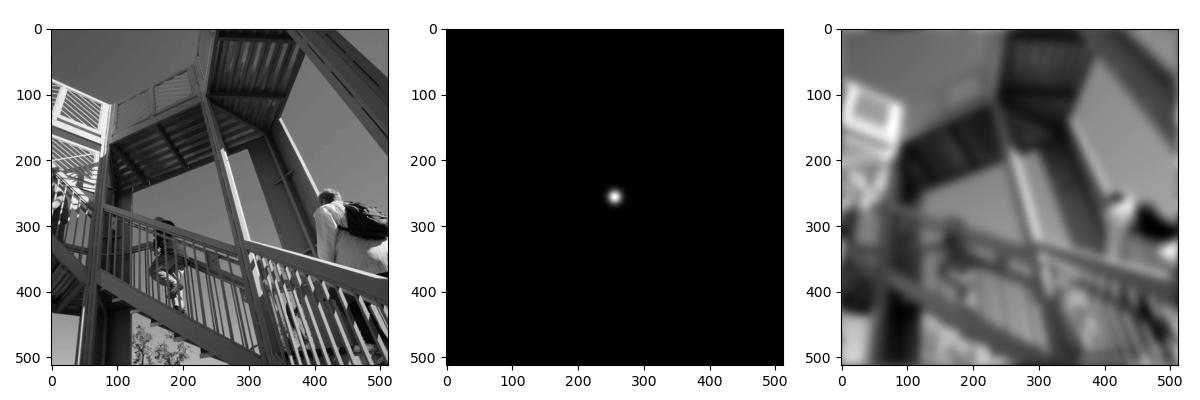

In [4]:
# Try inplace C2C VkFFT convolve
d_gpu = cla.to_device(cq, d.astype(np.complex64))
g_gpu = cla.to_device(cq, g.astype(np.complex64))

k_gpu = fftn(g_gpu)

app = VkFFTApp(d.shape, dtype=np.complex64, queue=cq, ndim=2, inplace=True,convolve=True, convolve_conj=0)
gd_gpu = app.fft(src=d_gpu,convolve_kernel=k_gpu)
print(app, app.get_tmp_buffer_str())

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(d, cmap='gray')
plt.subplot(132)
plt.imshow(np.fft.fftshift(g), cmap='gray')
plt.subplot(133)
plt.imshow(abs(gd_gpu.get()), cmap='gray')
plt.tight_layout()


VkFFTApp[OpenCL]:(512,512)       C2C/s/o [rr] [11] buf=    0       0  


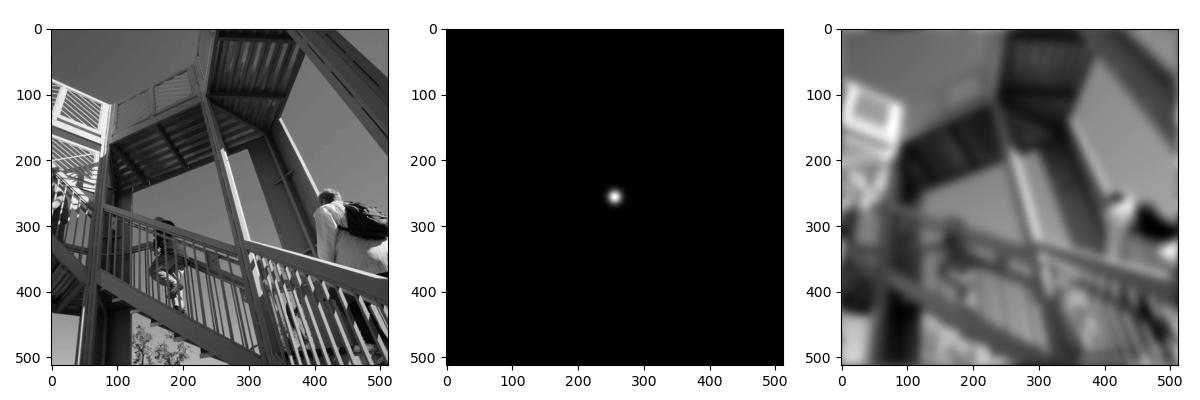

In [5]:
# Try out-of-place C2C VkFFT convolve
d_gpu = cla.to_device(cq, d.astype(np.complex64))
g_gpu = cla.to_device(cq, g.astype(np.complex64))
gd_gpu = cla.empty_like(d_gpu)

k_gpu = fftn(g_gpu)

app = VkFFTApp(d.shape, dtype=np.complex64, queue=cq, ndim=2, inplace=False,convolve=True, convolve_conj=0, convolve_norm=0)
gd_gpu = app.fft(src=d_gpu, dest=gd_gpu,convolve_kernel=k_gpu)
print(app, app.get_tmp_buffer_str())

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(d, cmap='gray')
plt.subplot(132)
plt.imshow(np.fft.fftshift(g), cmap='gray')
plt.subplot(133)
plt.imshow(abs(gd_gpu.get()), cmap='gray')
plt.tight_layout()
